In [1]:
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
session.set_keyspace('data_stock')

In [3]:
rows_price = session.execute("""
    SELECT * FROM candlestick_data ALLOW FILTERING
""")
df_cand = pd.DataFrame(rows_price)
df_cand['time'] = pd.to_datetime(df_cand['time'])
df_cand = df_cand.sort_values(['symbol', 'time'])


In [4]:
rows_fin2 = session.execute("""
    SELECT symbol,eps,pe,pbv,percentYield FROM financal_data_fromsettradeAPI ALLOW FILTERING
""")
df_fun= pd.DataFrame(rows_fin2)
df_fun.head(10)

,symbol,eps,pe,pbv,percentyield
0,PPPM,0.02000,0.00,0.70,0.00
1,TPCH,0.24112,7.90,0.34,13.91
2,KPNREIT,NaN,NaN,0.23,0.00
3,POLY,0.27632,12.89,2.42,6.38
4,QHBREIT,NaN,NaN,0.41,0.00
5,VCOM,0.21428,7.85,1.48,10.79
6,KDH,4.12186,10.62,1.93,3.01
7,NVD,-0.00942,38.87,0.32,0.00
8,JDF,0.04224,12.19,1.35,4.85
9,SVR,-0.03402,0.00,0.34,0.00


In [5]:
candlestick_data=df_cand
candlestick_data["time"] = pd.to_datetime(candlestick_data["time"])
# ✅ ดึงแท่งเทียนล่าสุดของแต่ละ symbol
latest_candle = candlestick_data.sort_values("time").groupby("symbol").tail(1)
latest_candle.shape

(912, 8)

In [6]:
# ✅ 1) ดึงแท่งล่าสุดของแต่ละ symbol
df_latest_candle = (
    df_cand.sort_values("time")
    .groupby("symbol", as_index=False)
    .tail(1)  # หรือใช้ .last() ก็ได้หลัง sort แล้ว
)

# ✅ 2) Merge กับข้อมูล fundamental
df = pd.merge(df_fun, df_latest_candle, on="symbol", how="inner")

# ✅ 3) คำนวณ marketcap
df["marketcap"] = df["close_price"] * df["volume"]


In [7]:
df = df.drop(columns=['time', 'close_price',
       'high_price', 'low_price', 'open_price', 'value', 'volume',])

In [8]:
import ta
def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []

    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()
        df_sym['ema5'] = df_sym['close_price'].ewm(span=5, adjust=False).mean()
        df_sym['ema15'] = df_sym['close_price'].ewm(span=15, adjust=False).mean()
        df_sym['ema35'] = df_sym['close_price'].ewm(span=35, adjust=False).mean()
        df_sym['ema89'] = df_sym['close_price'].ewm(span=89, adjust=False).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200, adjust=False).mean()
        df_sym['rsi'] = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()

        # ใช้แท่งล่าสุดในการประเมิน
        row = df_sym.iloc[-1]
        try:
            c = row['close_price']
            r = row['rsi']
            e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']

            if c >= e5 and r >= 70:
                grade = 'a'
            elif c >= e35 and e35 >= e89:
                grade = 'b'
            elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
                grade = 'c'
            elif c < e89 and c < e200 and e89 < e200:
                grade = 'd'
            elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
                grade = 'e'
            else:
                grade = None
        except:
            grade = None

        df_result.append({'symbol': symbol, 'trend_grade': grade})

    return pd.DataFrame(df_result)

In [9]:
df_result = compute_technical_grades(df_cand)    

In [10]:
df_result.dropna(inplace=True)

In [11]:
# ✅ Clustering กลุ่ม A–E ด้วย KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
df.loc[X.index, 'group'] = kmeans_labels

group_map = {i: chr(65+i) for i in range(5)}
df['group'] = df['group'].map(group_map)

In [12]:
# ✅ 1) สมมติว่า df_graded มี: symbol | trend_grade
#         และ df มี:        symbol | group

# ✅ 2) Merge โดยใช้คอลัมน์ 'symbol'
df_merged = pd.merge(df, df_result[['symbol', 'trend_grade']], on='symbol', how='inner')

# ✅ 3) สร้างคอลัมน์ quadrant (เช่น Aa, Be, Dc, etc.)
df_merged['quadrant'] = df_merged['group'] + df_merged['trend_grade']

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_tabnet.tab_model import TabNetClassifier

In [16]:
# ✅ Features และ Quadrant (สมมุติ df เตรียมไว้แล้ว)
features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
df = df_merged.dropna(subset=features + ['group', 'trend_grade'])
df['quadrant'] = df['group'] + df_result['trend_grade']  # เช่น 'Aa', 'Bb'

C:\Users\Admin\AppData\Local\Temp\ipykernel_20888\1280323607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quadrant'] = df['group'] + df_result['trend_grade']  # เช่น 'Aa', 'Bb'


In [17]:
le = LabelEncoder()
y = le.fit_transform(df['quadrant'])
scaler = StandardScaler()
X = scaler.fit_transform(df[features])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# ✅ Model 1: ANN
class ANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

ann = ANN(X_train.shape[1], len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001)

for epoch in range(50):
    ann.train()
    optimizer.zero_grad()
    output = ann(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

y_pred_ann = torch.argmax(ann(X_test_tensor), axis=1).numpy()


In [39]:
# ✅ กรองเฉพาะคลาสที่มีอย่างน้อย 2 แถว
from collections import Counter

# แปลง label เป็น DataFrame ชั่วคราว
df_y = pd.DataFrame({'label': y})
valid_classes = df_y['label'].value_counts()[lambda x: x >= 2].index

# Filter ทั้ง X และ y
mask = df_y['label'].isin(valid_classes)
X_filtered = X[mask]
y_filtered = y[mask]
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_filtered
)
clf_tabnet.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)
# ✅ ทำนายด้วย TabNet
y_pred_tabnet = clf_tabnet.predict(X_test)



epoch 0  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_accuracy: 0.02721 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.02721


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [35]:
# 1. กรอง class ที่มีข้อมูล ≥2
from collections import Counter
from sklearn.preprocessing import LabelEncoder

df_temp = pd.DataFrame({'label': y})
valid_classes = df_temp['label'].value_counts()[lambda x: x >= 2].index
mask = df_temp['label'].isin(valid_classes)

X_filtered = X[mask]
y_filtered = y[mask]

# 2. ✅ Re-encode y ใหม่
le_new = LabelEncoder()
y_filtered_encoded = le_new.fit_transform(y_filtered)

# 3. แบ่ง train/test แบบ stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_filtered_encoded
)
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf_xgb.fit(X_train, y_train)  # ✅ No error
y_pred_xgb = clf_xgb.predict(X_test)



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [11:27:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [25]:
# ✅ Model 4: Random Forest
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [40]:
# ✅ Evaluation Function
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1
acc_ann, f1_ann = evaluate(y_test, y_pred_ann)
acc_tabnet, f1_tabnet = evaluate(y_test, y_pred_tabnet)
acc_xgb, f1_xgb = evaluate(y_test, y_pred_xgb)
acc_rf, f1_rf = evaluate(y_test, y_pred_rf)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20888\1195726091.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


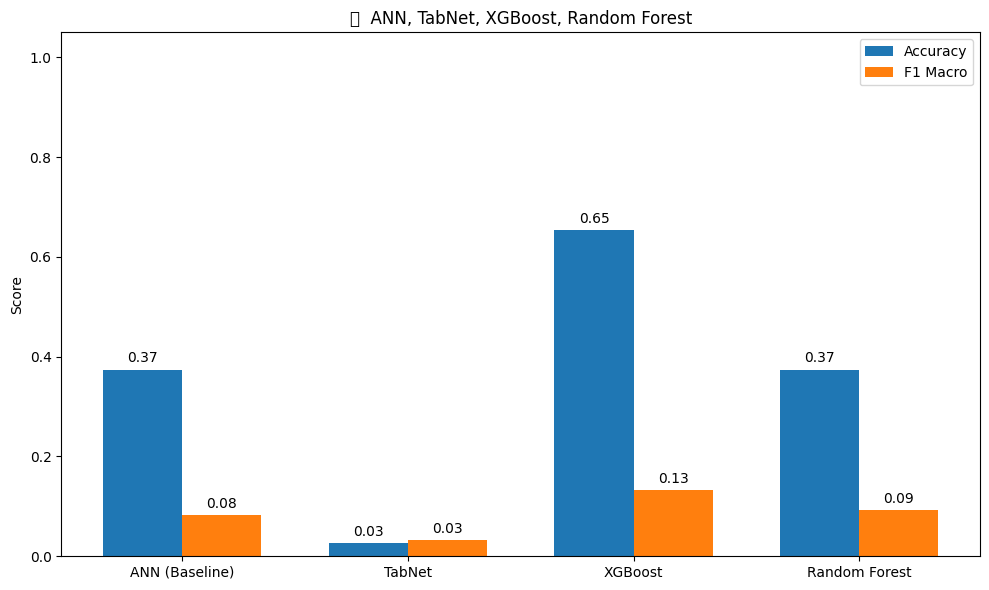

In [42]:
# ✅ Bar Chart
models = ['ANN (Baseline)', 'TabNet', 'XGBoost', 'Random Forest']
accuracies = [acc_ann, acc_tabnet, acc_xgb, acc_rf]
f1_scores = [f1_ann, f1_tabnet, f1_xgb, f1_rf]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Macro')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

ax.set_ylabel('Score')
ax.set_title('📊  ANN, TabNet, XGBoost, Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()